## Prevendo valores de ações com algoritmos de machine learning e deep learning 🎯

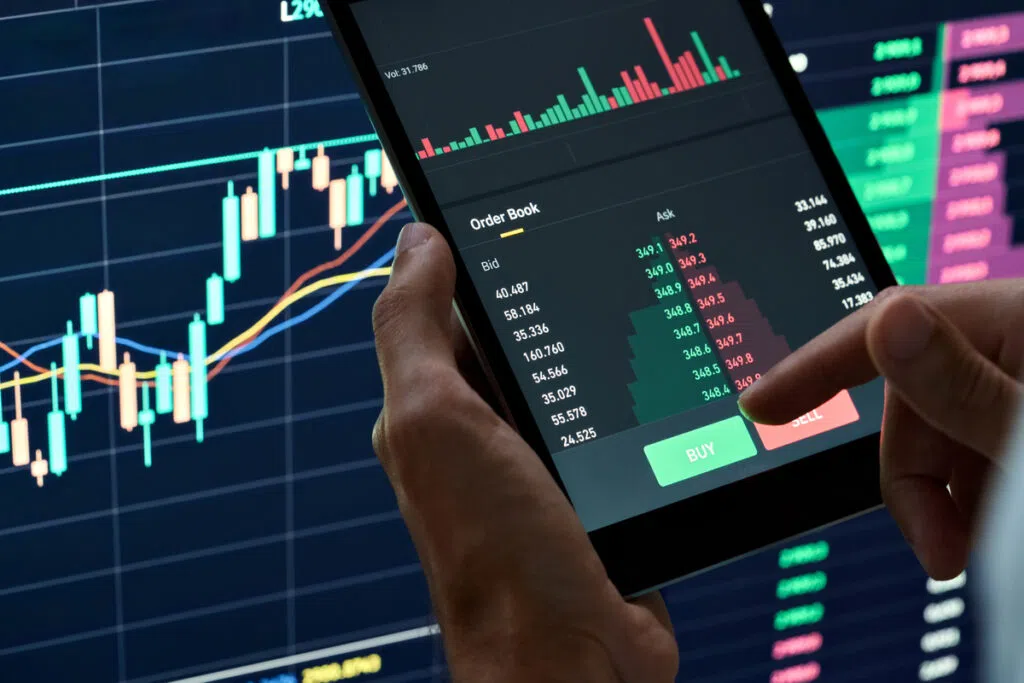

O objetivo desta aula é realizarmos 4 tipos de testes de predição de séries temporais!

Vamos utilizar desde modelos mais tradicionais como a **média móvel** e o **ARIMA**, até modelos mais robusto como o **prophet** do Facebook (Meta) e ainda a deep learning **LSTM**. Vamos lá?

## Sobre o dataset 🎲

O dataset é composto pelo histórico do valor das ações da **Disney** no período de *01/01/2018 até 11/12/2023*.

Link para acessar dados do Yahoo Finanças:

https://br.financas.yahoo.com/quote/MSFT/history?period1=1420070400&period2=1652918400&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true


### Importando as bibliotecas necessárias:

In [1]:
#!pip uninstall -y fbprophet
#!pip uninstall -y pystan
#!pip install fbprophet
#!pip install pystan==2.19.1.1

In [2]:
# Bibliotecas básicas de data science
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
%matplotlib inline

# Para baixar os dados
import yfinance as yf


#Para aplicar o ARIMA:
from statsmodels.tsa.stattools import adfuller          #verificar dados estacionários
from statsmodels.tsa.stattools import acf, pacf         #correlação
from statsmodels.tsa.seasonal import seasonal_decompose #Decomposição sazonal usando médias móveis.
from statsmodels.tsa.arima.model import ARIMA           #algoritmo arima

# Para deep learning
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
from keras.preprocessing.sequence import TimeseriesGenerator

# Para machine learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

# Prophet
from prophet import Prophet

### Upload do dataframe:

In [3]:
import yfinance as yf

# Especifique o símbolo da Disney (DIS) e o intervalo de datas desejado
symbol = 'DIS'
start_date = '2018-01-01'
end_date = '2023-12-11'

# Use a função download para obter os dados
df = yf.download(symbol, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [4]:
df = df.reset_index('Date')
df['Date'] = pd.to_datetime(df['Date']) #realizando a conversão da data para formato datetime
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,108.949997,111.809998,108.559998,111.800003,108.372864,11014300
1,2018-01-03,112.190002,113.190002,111.449997,112.279999,108.838142,9237900
2,2018-01-04,112.949997,113.000000,111.629997,112.230003,108.789680,7417400
3,2018-01-05,112.680000,112.680000,111.239998,111.620003,108.198372,6008300
4,2018-01-08,110.889999,111.279999,109.540001,110.019997,106.647415,8052600


In [5]:
df.shape #analisando linhas e colunas

(1495, 7)

In [6]:
df_disney = df # criando cópia do dataset

### Visualizando os valores de fechamento

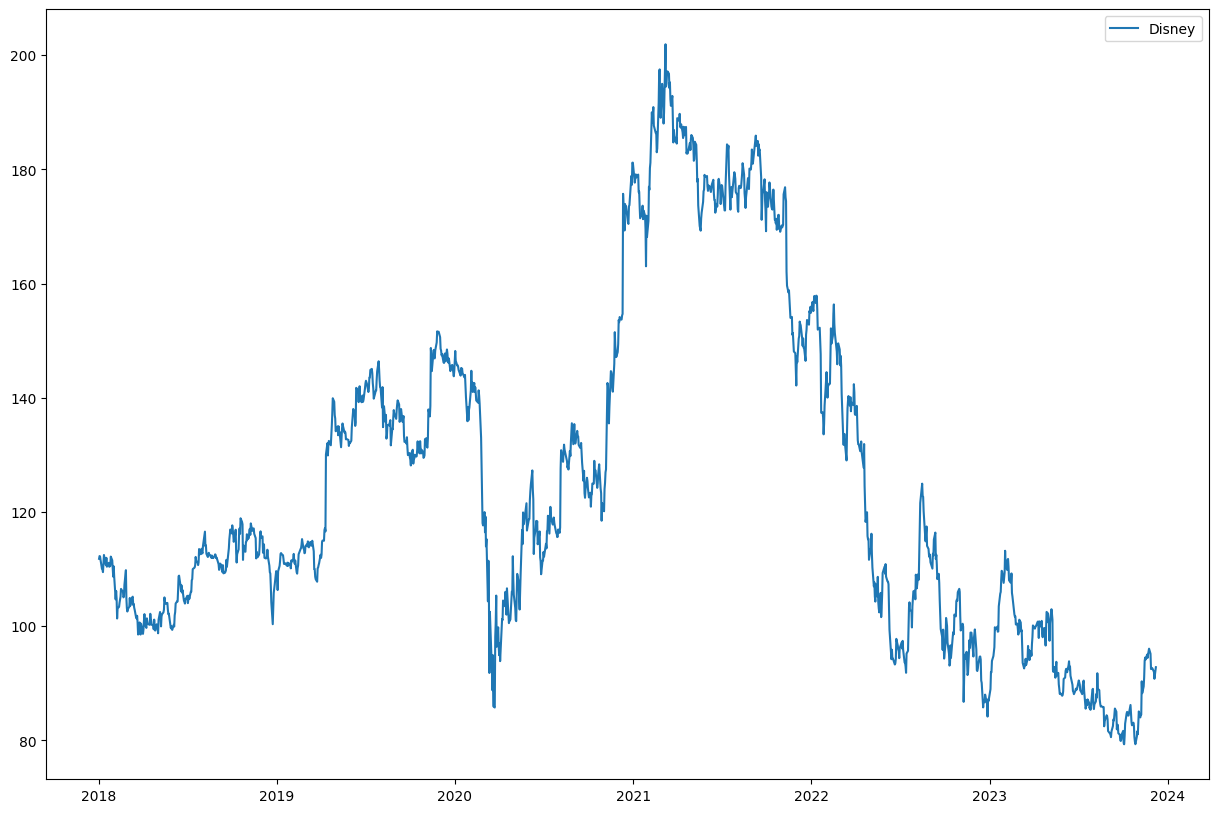

In [7]:
plt.figure(figsize = (15,10))
plt.plot(df['Date'], df['Close'], label='Disney')

plt.legend(loc='best')
plt.show()

# Análise de série temporal (Decomposição) 📈

Dentro das etapas de análise de uma série temporal, existe a etapa da realização de sua decomposição. Decompor uma série temporal significa você analisar:

- Tendencia
- Sazonalidade
- Ruído

Iremos utilizar o Statsmodel para decompor nossos dados e visualizar vários gráficos. Utilizar a decomposição dos dados da série pode **auxiliar na compreensão dos dados e na tomada de decisão de qual modelo preditivo utilizar**.

Ao compreender a tendência, podemos fazer previsões de longo prazo.

Ao entender a sazonalidade, podemos prever padrões de curto prazo.

E ao analisar os resíduos, podemos entender o que não foi capturado pelos dois primeiros componentes e, assim, melhorar nossos modelos. 😊

## O que é tendência?
**Direcionamento** de sua série temporal (para qual direção ela está indo).

## O que é Sazonalidade?
Encontrar **caracteristicas e padrões no tempo** que podem aparecer de forma repetida.

## O que é o ruído?
Após extrair a tendência e a sazonalidade da série original, o que resta é chamado de resíduo. Os resíduos são a **diferença entre a série original e o que foi explicado pela tendência e sazonalidade**.

## Série aditiva ou multiplicativa

A decomposição pode ajudar a identificar se uma série temporal é **aditiva ou multiplicativa**. Uma série é considerada **aditiva** quando a **magnitude da sazonalidade e da tendência não varia com o tempo**. Por outro lado, em uma série **multiplicativa**, a **magnitude da sazonalidade ou da tendência varia em proporção ao nível da série.**



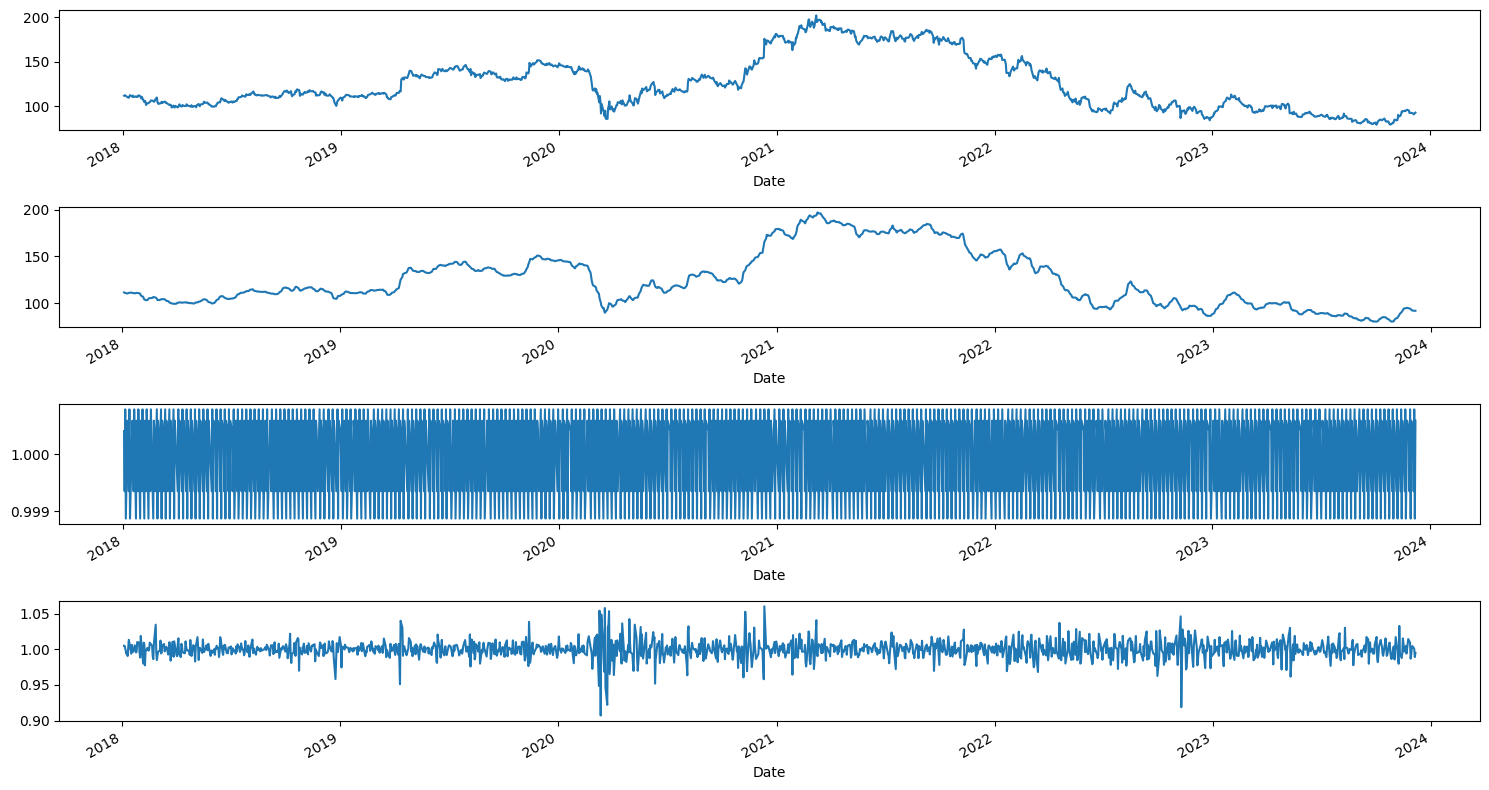

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

df_limpo = df                                                              # cópia do dataframe
df_limpo['Date'] = pd.to_datetime(df_limpo['Date'])                        # transformando em datetime
df_limpo = df.drop(columns=['Open', 'High', 'Low', 'Volume', 'Adj Close']) # Removendo colunas desnecessárias
df_limpo = df_limpo.set_index('Date')                                      # definindo data como índice

################################## Notas da análise de decomposição da série ########################################

# model='additive': Este parâmetro especifica o tipo de modelo utilizado na decomposição.

# Os dois tipos principais são:

# "additive" (modelo apropriado quando a magnitude da sazonalidade não varia com a tendência)
# "multiplicative" (modelo é mais apropriado quando a magnitude da sazonalidade varia com a tendência).

# period: Este é o período da sazonalidade. Ele especifica o número de observações em um ciclo sazonal.

######################################################################################################################

seasonplot = seasonal_decompose(df_limpo, model='multiplicative', period=5) #decopondo a série temporal
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15,8))
seasonplot.observed.plot(ax=ax1) #serie real
seasonplot.trend.plot(ax=ax2)    #tendencia
seasonplot.seasonal.plot(ax=ax3) #sazonalisade
seasonplot.resid.plot(ax=ax4)    #residuos
plt.tight_layout()

In [9]:
df_limpo

,Close
Date,
2018-01-02,111.800003
2018-01-03,112.279999
2018-01-04,112.230003
2018-01-05,111.620003
2018-01-08,110.019997
...,...
2023-12-04,92.010002
2023-12-05,90.790001
2023-12-06,91.500000


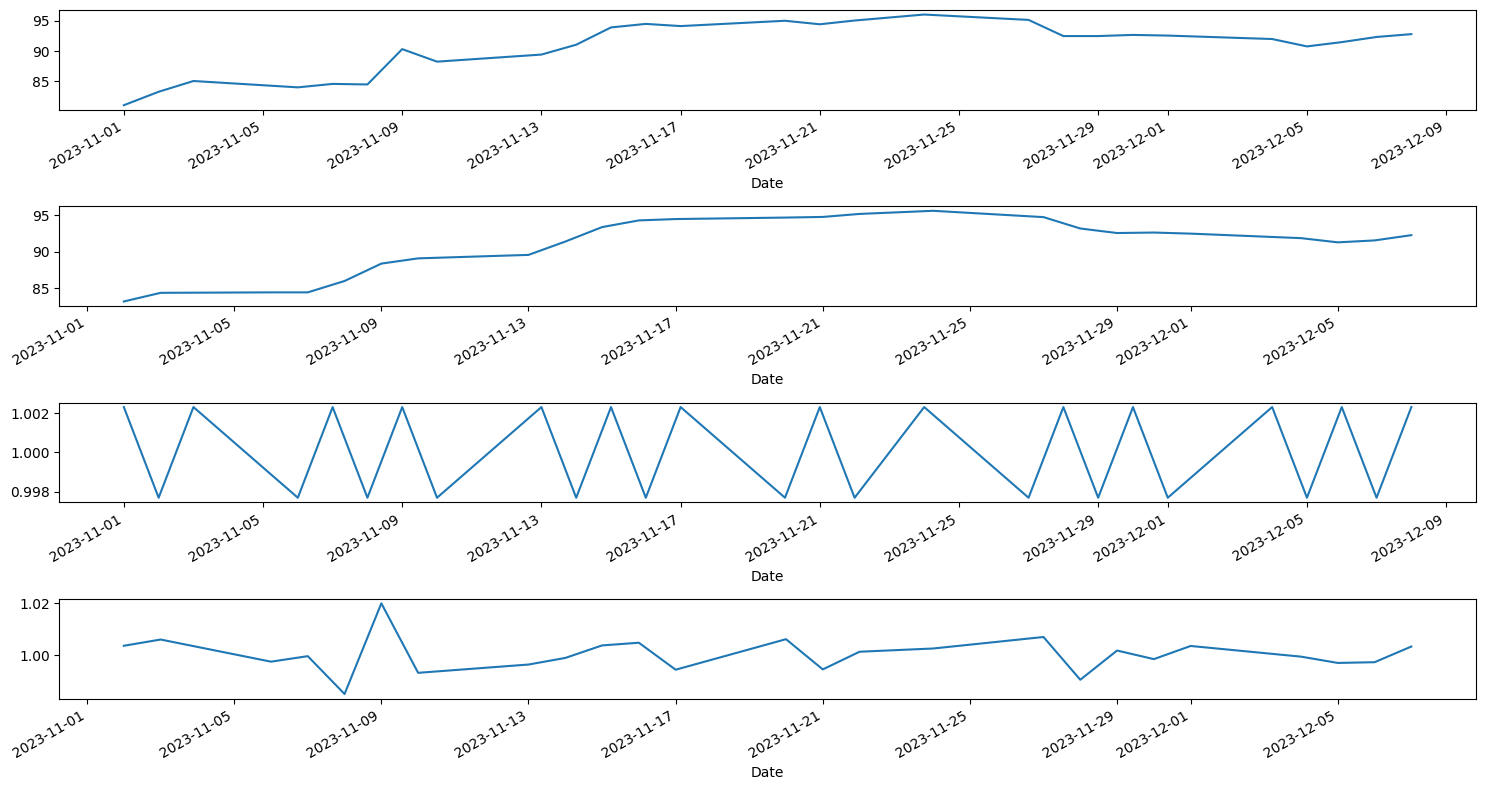

In [10]:
df_2023 = df_limpo.loc['2023-11-01':]
seasonplot = seasonal_decompose(df_2023, model='multiplicative', period=2) #decopondo a série temporal
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15,8))
seasonplot.observed.plot(ax=ax1) #serie real
seasonplot.trend.plot(ax=ax2)    #tendencia
seasonplot.seasonal.plot(ax=ax3) #sazonalisade
seasonplot.resid.plot(ax=ax4)    #residuos
plt.tight_layout()

## E por que as ações estão caindo? 🏰✨

**Uma das possíveis causas:** Pandemia do covid trouxe grandes impcatos que a disney está enfrentando até os dias de hoje (em 2023).

**Recomendação de vídeo:** https://youtu.be/v7ybYLS9tTo?si=mSIneB3BLd-YbEn9


✨**Dica:** Na análise exploratória, não vale apenas olhar para os dados, mas também entender o que aconteceu com o mundo, a economia e todos os fatores externos que podem ter impactado as variações da série temporal.

## Testando modelos clássicos: Média Móvel 📈⏳

Um algoritmo clássico para este tipo de problema é o da Média Móvel. Ele consiste em utilizar a **média de N dias observados para prever o próximo dia**. Vamos utilizar esta técnica para um N de 10 e de 20 dias.


In [11]:
#Filtrando os dados
df = pd.DataFrame(df[['Close','Date']])
df.set_index('Date', inplace=True)

In [12]:
df['MA_window_10'] = df['Close'].rolling(10).mean().shift() #média móvel em 10 dias
df['MA_window_20'] = df['Close'].rolling(20).mean().shift() #média móvel em 20 dias

#Rolling para deslocamento. Este parâmetro especifica o número de observações usadas para calcular a estatística
#shift é utilizado para deslocar o índice de DataFrame por um número especificado de períodos com uma freqüência de tempo opcional

In [13]:
df.head(20)

,Close,MA_window_10,MA_window_20
Date,,,
2018-01-02,111.800003,NaN,NaN
2018-01-03,112.279999,NaN,NaN
2018-01-04,112.230003,NaN,NaN
2018-01-05,111.620003,NaN,NaN
2018-01-08,110.019997,NaN,NaN
2018-01-09,109.940002,NaN,NaN
2018-01-10,109.470001,NaN,NaN
2018-01-11,110.989998,NaN,NaN
2018-01-12,112.470001,NaN,NaN


### Visualizando o resultado:

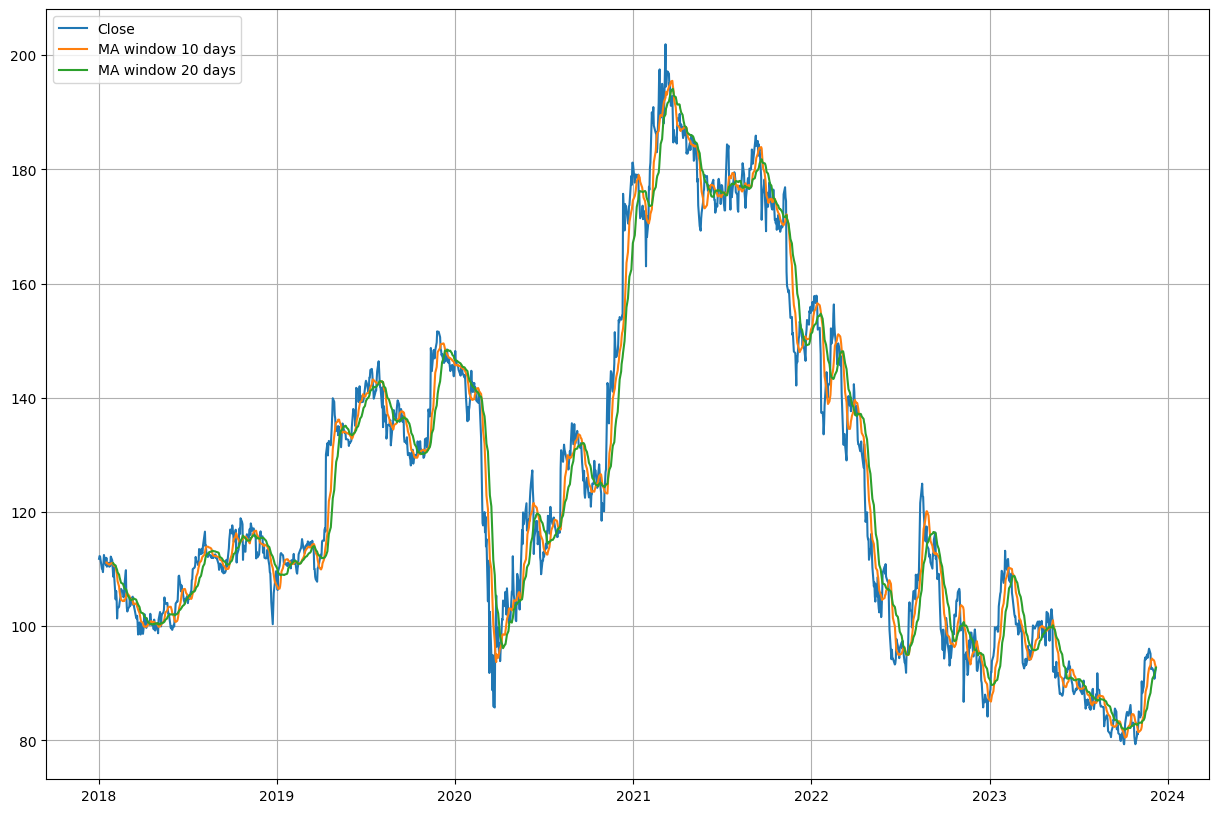

In [14]:
plt.figure(figsize=(15,10))
plt.grid(True)
plt.plot(df['Close'], label='Close')
plt.plot(df['MA_window_10'], label='MA window 10 days')
plt.plot(df['MA_window_20'], label='MA window 20 days')
plt.legend(loc=2)
plt.show()

### Visualizando os dados mais recentes: últimos 300 dias

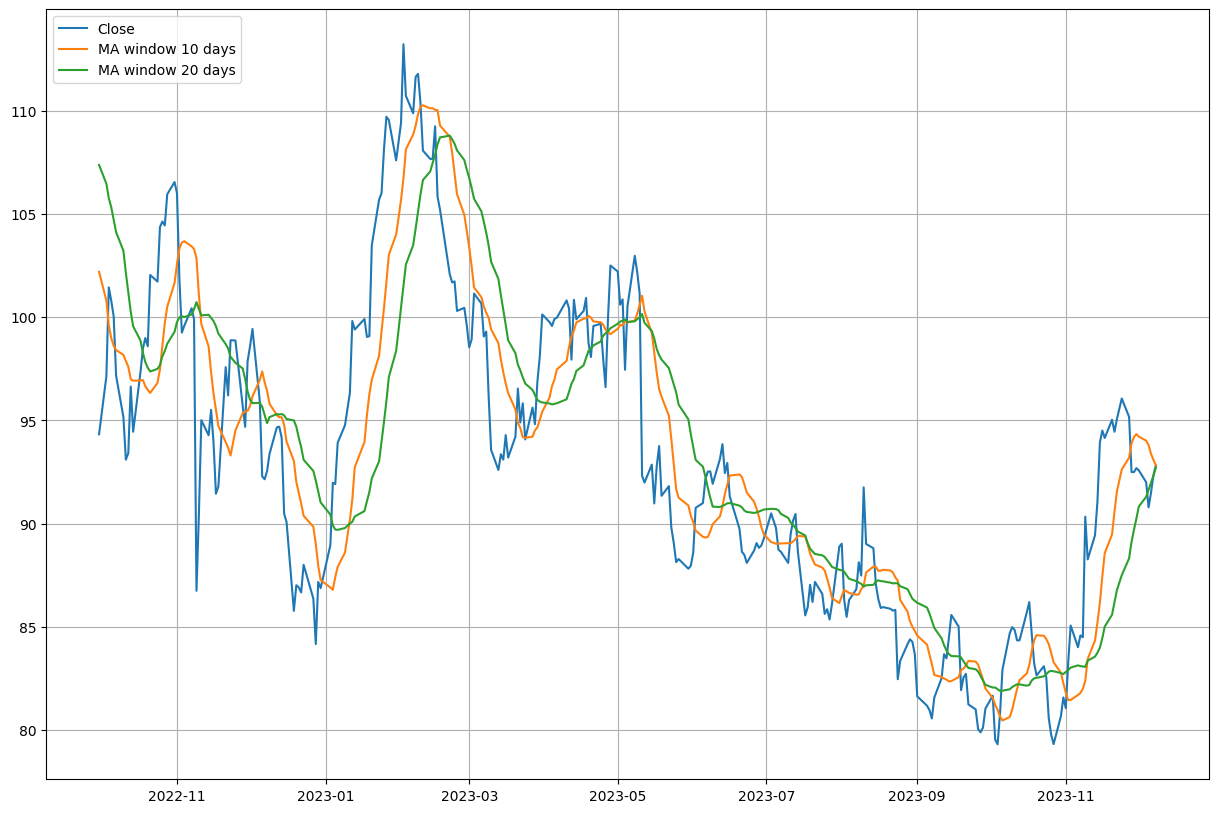

In [15]:
limit = 300

plt.figure(figsize=(15,10))
plt.grid(True)
plt.plot(df['Close'][-limit:], label='Close')
plt.plot(df['MA_window_10'][-limit:], label='MA window 10 days')
plt.plot(df['MA_window_20'][-limit:], label='MA window 20 days')
plt.legend(loc=2)
plt.show()

### Prevendo os "N" dias com base na média móvel aritmética

In [16]:
df['MA_window_10_forward_10'] = np.NaN #preechendo com NaN os valores da coluna de MA_window_10_forward_10

In [17]:
def make_window(window_size, start_point):
    return [start_point+x for x in range(window_size)]  #realizando a janela de tempo

In [18]:
window_size = 10
forward_days = 10

# Iteração sobre a série temporal com uma janela deslizante
for index in range(window_size, len(df), forward_days):

    # Iteração para calcular a média móvel ponderada
    for i in range(0, forward_days):
        # Verifica se o índice atual está dentro dos limites da série temporal
        if index + i >= len(df):
            break

        # Criando duas janelas:
        # 1. Uma janela para a média móvel ('window_close')
        # 2. Uma janela para a série temporal original ('window_MA')
        window_close = make_window(window_size - i, index + i - window_size)
        window_MA = make_window(i, index)

        # Calculando a média móvel ponderada
        mean = pd.concat([df['Close'].iloc[window_close], df['MA_window_10_forward_10'].iloc[window_MA]]).mean(axis=0)

        # Atualizando o DataFrame com a média móvel ponderada
        df.iat[index + i, df.columns.get_loc('MA_window_10_forward_10')] = mean


Plotando os dados:

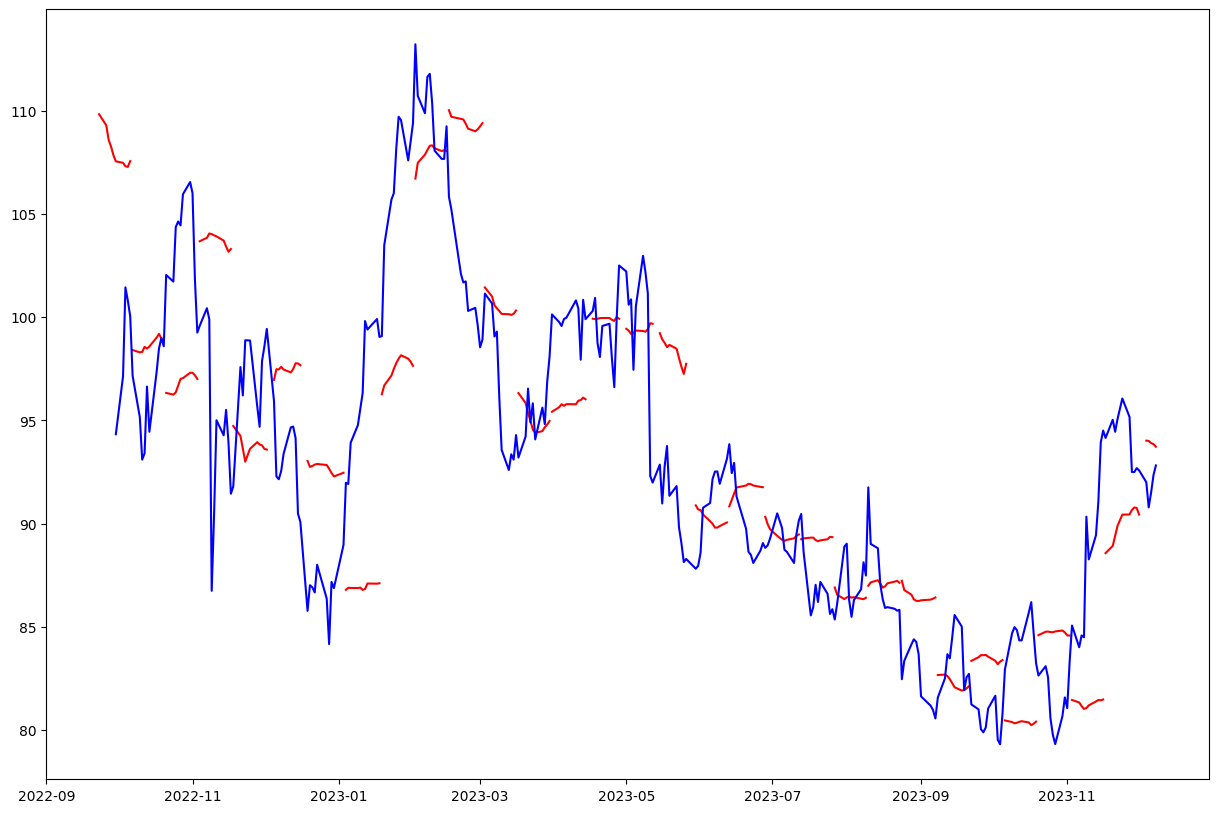

In [19]:
plt.figure(figsize = (15,10))

size = len(df)-limit - (len(df)-limit)%forward_days

for index in range(size, len(df), forward_days):
    plt.plot(df['MA_window_10_forward_10'][index:index+forward_days], color='r')

plt.plot(df['Close'][-limit:], color='b', label='Close')
#plt.legend(loc='best')
plt.show()

Note que cada reta vermelha no gráfico representa uma previsão de 10 dias, baseado nos 10 dias anteriores. Por isso elas são descontínuas.

Este tipo de abordagem é muito simplista. Isto porque o verdadeiro objetivo é prever N dias a frente para ver qual será o comportamento da ação. E ambos algoritmos falham nessa função. Vamos testar mais um clássico? Vamos analisar como o ARIMA funciona.

## Testando o modelo ARIMA 💹

ARIMA significa **Média Móvel Integrada Auto-Regressiva**.

Um modelo ARIMA é uma classe de modelos estatísticos para analisar e prever dados de séries temporais. Enquanto os modelos de suavização exponencial são baseados na descrição da tendência e sazonalidade dos dados, os modelos ARIMA visam descrever as **autocorrelações nos dados**.

---
O algoritmo ARIMA utiliza **autoregressão** + **médias móveis** + **diferenciação**.

---

 Os **termos autoregressivos** permitem que o **modelo capture a influência dos valores passados na série temporal**. Os termos de **média móvel permitem que o modelo capture os erros de previsão passados**. A **diferenciação permite que o modelo capture tendências** na série temporal.


❗ Antes de falarmos sobre o modelo ARIMA, vamos falar sobre o conceito de **estacionariedade** e a técnica de **diferenciação** de séries temporais.

**O que é estacionaridade? 🤔**

Para trabalhar com séries temporais utilizando o modelo ARIMA, precisamos que ela **seja estacionária**. Essa característica além de ser necessária para algum modelos, facilita a projeção dos dados. Portanto é considerado uma série estacionaria aquela série que em ***certos períodos possui a mesma média***.

A tendência e a sazonalidade afetarão o valor da série temporal em momentos diferentes. Por outro lado, para a estacionaridade, não importa quando você a observa, ela deve parecer a mesma em qualquer momento. Em geral, uma série temporal estacionária não terá padrões previsíveis no longo prazo.

### Hiperparâmetros do algortimo:

- P - Número de **lags** que devem ser incluídos no modelo *(lags são valores auto correlacionados que devem ser levados em consideração, ou seja, os valores históricos que serão utilizados para prever o futuro.*)
- D - Número de vezes que as **observações serão diferenciadas**. (*tornar a série estacionária*)
- Q - Ordem de média móvel, **tamanho de uma janela (lag) de média móvel**.(*para calcular o erro e encontrar a melhor previsão (tamanho da janela da media móvel) para calcular os residuos e fazer o forecast*).

### Passos para aplicar o ARIMA:

1. Visualize os dados da série temporal 📈
2. Identifique se a data é estacionária ✅
3. Plote os gráficos de correlação e autocorrelação 🤔
4. Construir o modelo ARIMA com base nos dados 🔨

## Analisando a correlação dos dados:

Ao trabalhar com modelos ARIMA, uma etapa importante é **entender a autocorrelação presente nos dados**. A autocorrelação refere-se à correlação de uma série temporal com uma versão atrasada de si mesma. Para entender e visualizar essa autocorrelação, utilizamos as funções de autocorrelação (ACF) e autocorrelação parcial (PACF).

#### Autocorrelação e Autocorrelação parcial:

- ACF (autocorrelação) temos a correlação direta e indireta.
- PACF (autocorrelação parcial): apenas a correlação direta.

A ACF é uma ferramenta valiosa para entender padrões de dependência temporal nos dados. Os lags são os intervalos de atraso entre as observações. Cada ponto no gráfico indica a correlação entre a série temporal e ela mesma em diferentes pontos no passado.

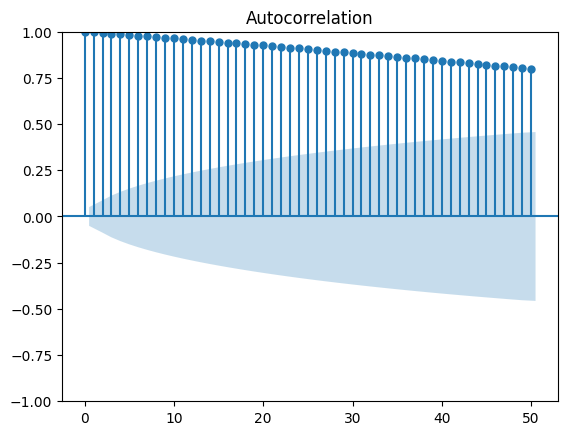

In [20]:
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(df_limpo, lags=50)
plt.show()

O intervalo de confiança por padrão é 95%, mostrado como essa marca em azul. Observações que estão para fora da marca são consideradas estatisticamente correlacionadas.

A interpretação do ACF geralmente envolve identificar padrões significativos de autocorrelação nos lags. Se a autocorrelação em um determinado lag for significativa (por exemplo, ultrapassando linhas pontilhadas que indicam intervalos de confiança), isso sugere uma possível sazonalidade ou padrão repetitivo nos dados.

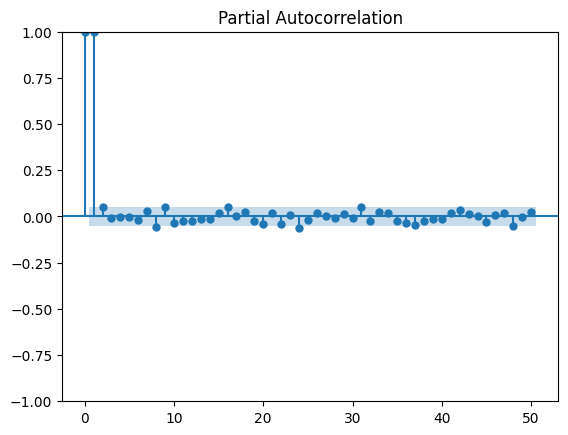

In [21]:
sm.graphics.tsa.plot_pacf(df_limpo, lags=50)
plt.show()

Fazendo a análise de correlação parcial direta, os lags não contribuem significativamente para a estrutura da autocorrelação parcial após considerar os efeitos dos lags intermediários (veja os lags na área em azul).

A interpretação do PACF geralmente está relacionada à identificação do atraso específico que contribui para a autocorrelação em um determinado ponto. Ou seja, **ajuda a identificar a ordem de defasagem apropriada para um modelo AR (autoregressivo)**. Neste caso, podemos observar que a ordem de defasagem dessa série é observada em 2 lags.


## Analisando a média móvel com o desvio padrão



In [22]:
rolmean = df_limpo.rolling(window=12).mean() #média móvel em 12 meses (dando a média móvel no nível anual).
rolstd = df_limpo.rolling(window=12).std()   #Desvio padrão em 12 meses
print(rolmean,rolstd)

                Close
Date                 
2018-01-02        NaN
2018-01-03        NaN
2018-01-04        NaN
2018-01-05        NaN
2018-01-08        NaN
...               ...
2023-12-04  93.893333
2023-12-05  93.583333
2023-12-06  93.362500
2023-12-07  93.139167
2023-12-08  93.003333

[1495 rows x 1 columns]                Close
Date                
2018-01-02       NaN
2018-01-03       NaN
2018-01-04       NaN
2018-01-05       NaN
2018-01-08       NaN
...              ...
2023-12-04  1.360462
2023-12-05  1.608405
2023-12-06  1.702687
2023-12-07  1.638643
2023-12-08  1.586845

[1495 rows x 1 columns]


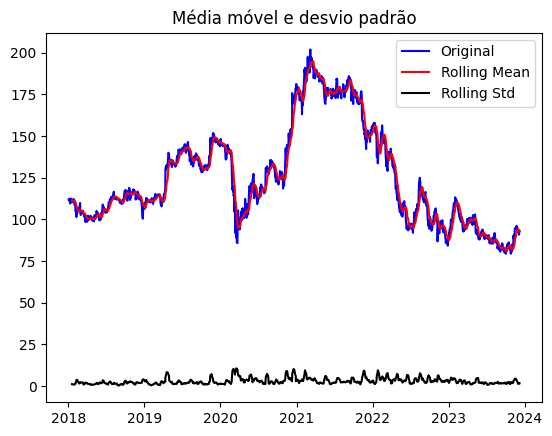

In [23]:
#Plotando a média móvel
orig = plt.plot(df_limpo, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Média móvel e desvio padrão')
plt.show(block=False)

No gráfico acima, vemos que a própria média móvel tem um componente de tendência, embora o desvio padrão contínuo seja bastante constante com o tempo. Para que nossa série temporal seja estacionária, precisamos garantir que ambas as estatísticas tenham uma tendência.

O desvio padrão é uma medida de dispersão que quantifica o quanto os valores em um conjunto de dados tendem a se afastar da média. Neste caso, podemos observar que os dados variam muito!

Mas, como podemos comprovar realmente que esta série temporal não é estacionária?


# Verificar estacionariedade da série temporal 📈

# Teste de Dickey-Fuller ✍


Para aumentar ainda mais nossa hipótese de que a série temporal não é estacionária, vamos realizar o teste ADCF:

O teste de ***Dickey-Fuller Aumentado (ADF)*** permite saber sem **há presença significativa de tendência nas séries temporais** das variáveis por meio de um teste de hipótese.



**Estatística ADF:**

- H0 (Hipótese Nula): A série temporal não é estacionária.

- H1 (Hipótese Alternativa): A série temporal é estacionária.


**Interpretação:** Se a estatística ADF for menor que os valores críticos, podemos rejeitar a hipótese nula e considerar a série temporal estacionária. Quanto mais negativa a estatística, mais forte é a evidência contra a hipótese nula.

**Valor p (p-value):**

**Interpretação:** Um valor p menor que um determinado nível de significância (**por exemplo, 0.05**) fornece evidência contra a hipótese nula, sugerindo que a série temporal é estacionária.

**Estacionariedade**
Para trabalhar com séries temporais em alguns modelos, precisamos que ela seja estacionária. Essa característica além de ser necessária para algum modelos, facilita a projeção dos dados. Portanto é considerado uma série estacionaria aquela série que em certos períodos possui a mesma média.

A tendência e a sazonalidade afetarão o valor da série temporal em momentos diferentes. Por outro lado, para a estacionaridade, não importa quando você a observa, ela deve parecer a mesma em qualquer momento. Em geral, uma série temporal estacionária não terá padrões previsíveis no longo prazo.

In [24]:
from statsmodels.tsa.stattools import adfuller

# Teste de estacionariedade (ADF Test)
adf_result = adfuller(df_limpo['Close'])
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
print('Resultados do Teste de Estacionariedade:')
print('--------------------------------------')
print('Teste Estatístico:', adf_result[0])
print('Valor-p:', adf_result[1])
print('Valores Críticos:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -1.4226978571153146
p-value: 0.5713474145935862
Resultados do Teste de Estacionariedade:
--------------------------------------
Teste Estatístico: -1.4226978571153146
Valor-p: 0.5713474145935862
Valores Críticos:
   1%: -3.43476120520139
   5%: -2.863488262178673
   10%: -2.567807233388883


Para que uma série temporal seja estacionária, seu teste ADCF:

- valor p alto (de acordo com a hipótese nula) (valor p no máximo pode ser 1)
- Os valores críticos em intervalos de confiança de 1%,5%,10% devem ser o mais próximo possível das Estatísticas de Teste.

Portanto, podemos dizer com segurança que nossa Série Temporal no momento **não** é estacionária.


# Transformando a série e estacionária

### 1º teste 🔍: subtrair os dados transformados pelo log pela média móvel.


**Objetivo:** Estabilizar a variância em uma série temporal, especialmente quando a amplitude dos dados varia ao longo do tempo.



---



Vamos utilizar o **logarítmo** para realizar a transformação dos dados. Nosso objetivo é **remover o componente de tendência**. Portanto, curvas mais planas (ou seja: paralelas ao eixo x) para séries temporais e médias contínuas após obter o log diriam que nossa transformação de dados fez um bom trabalho.

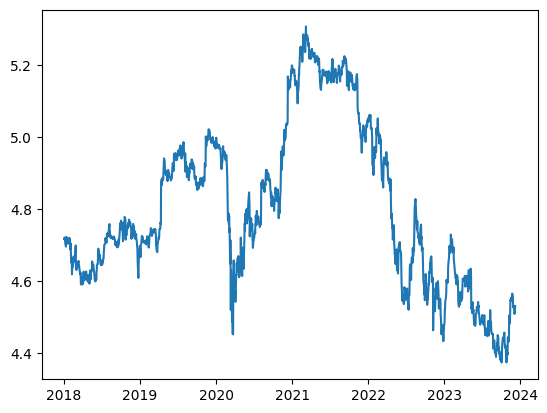

In [25]:
#Estimating trend
indexedDataset_logScale = np.log(df_limpo) #Transformação logarítma
plt.plot(indexedDataset_logScale)

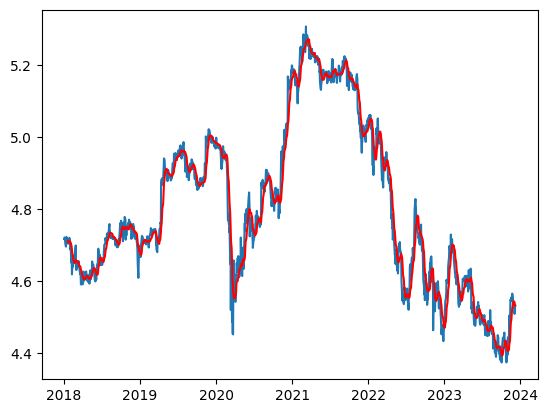

In [26]:
# Calculando a média móvel
movingAverage = indexedDataset_logScale.rolling(window=12).mean()
movingSTD = indexedDataset_logScale.rolling(window=12).std()
plt.plot(indexedDataset_logScale)
plt.plot(movingAverage, color='red')

Vamos subtrair os dados transformados pelo log menos a média móvel para remover o componente de tendência de ambos. (Aqui buscamos isolar os padrões sazonais ou os componentes residuais.)



In [27]:
datasetLogScaleMinusMovingAverage = indexedDataset_logScale - movingAverage
datasetLogScaleMinusMovingAverage.head(12)

#Remove NAN values
datasetLogScaleMinusMovingAverage.dropna(inplace=True)
datasetLogScaleMinusMovingAverage.head(10)

,Close
Date,
2018-01-18,-0.006624
2018-01-19,-0.004179
2018-01-22,0.001302
2018-01-23,-0.003565
2018-01-24,-0.001910
2018-01-25,-0.001858
2018-01-26,0.011180
2018-01-29,0.003808
2018-01-30,-0.008432


In [28]:
# Função para testar a estacionariedade da série transformada

def test_stationarity(timeseries):

    #Determinar estatísticas contínuas
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()

    #Plot estatísticas contínuas
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Performance do Dickey–Fuller:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['Close'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)


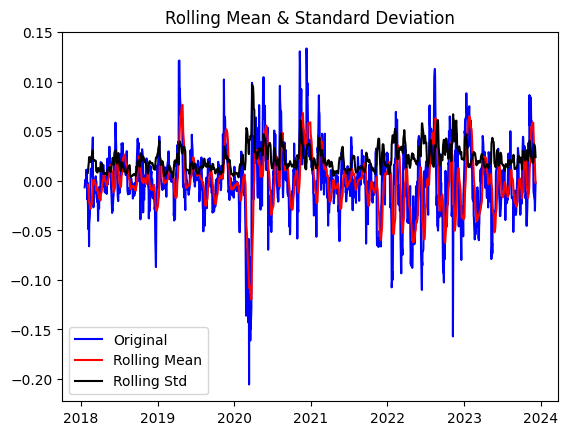

Results of Dickey Fuller Test:
Test Statistic                -9.801568e+00
p-value                        5.975904e-17
#Lags Used                     8.000000e+00
Number of Observations Used    1.475000e+03
Critical Value (1%)           -3.434791e+00
Critical Value (5%)           -2.863501e+00
Critical Value (10%)          -2.567814e+00
dtype: float64


In [29]:
test_stationarity(datasetLogScaleMinusMovingAverage)

### 2º teste : Decaimento exponencial.



---



**Objetivo:** Remover a tendência de uma série temporal. A ideia básica é aplicar uma média exponencial ponderada aos dados, atribuindo mais peso às observações mais recentes e menos peso às observações mais antigas.


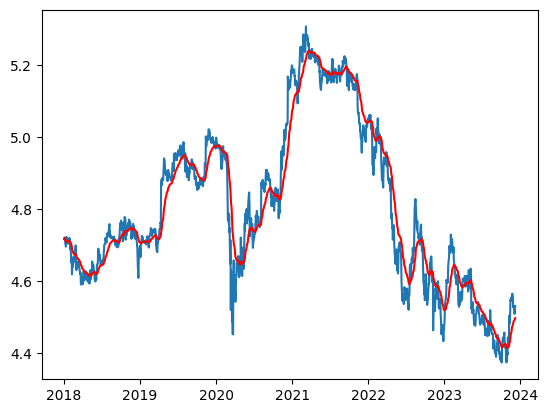

In [30]:
exponentialDecayWeightedAverage = indexedDataset_logScale.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(indexedDataset_logScale)
plt.plot(exponentialDecayWeightedAverage, color='red')

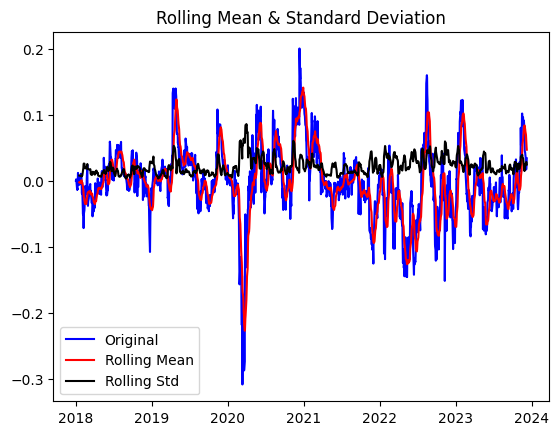

Results of Dickey Fuller Test:
Test Statistic                -5.978962e+00
p-value                        1.858179e-07
#Lags Used                     9.000000e+00
Number of Observations Used    1.485000e+03
Critical Value (1%)           -3.434761e+00
Critical Value (5%)           -2.863488e+00
Critical Value (10%)          -2.567807e+00
dtype: float64


In [31]:
# Subtraindo o dataset em escala logarítma pelo decaimento exponencial
datasetLogScaleMinusExponentialMovingAverage = indexedDataset_logScale - exponentialDecayWeightedAverage
test_stationarity(datasetLogScaleMinusExponentialMovingAverage)

### 3º teste : Diferenciação



---



**Objetivo:** Remover a tendência e tornar a série mais estacionária.

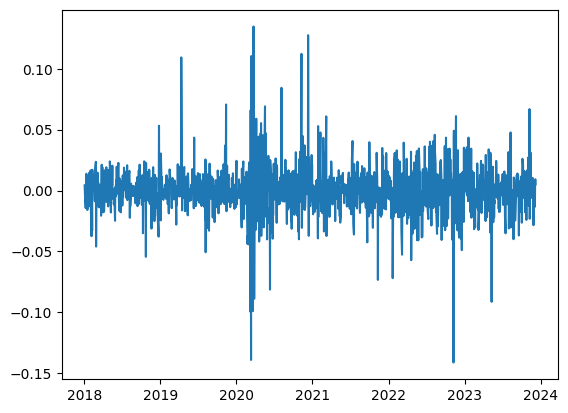

In [32]:
datasetLogDiffShifting = indexedDataset_logScale - indexedDataset_logScale.shift() #diferença entre o valor anterior e o atual
plt.plot(datasetLogDiffShifting)

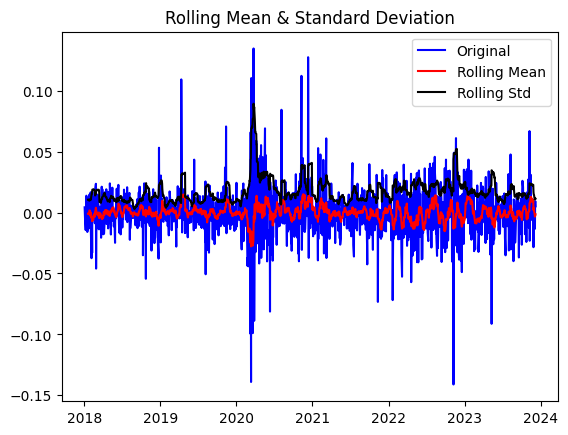

Results of Dickey Fuller Test:
Test Statistic                -1.233792e+01
p-value                        6.212274e-23
#Lags Used                     8.000000e+00
Number of Observations Used    1.485000e+03
Critical Value (1%)           -3.434761e+00
Critical Value (5%)           -2.863488e+00
Critical Value (10%)          -2.567807e+00
dtype: float64


In [33]:
datasetLogDiffShifting.dropna(inplace=True)
test_stationarity(datasetLogDiffShifting)

# Teste de correlação parcial

Como definimos numa primeira tentativa o parâmetro **P (lags: valores auto correlacionados)** e o parâmetro **Q (tamanho de uma janela)** do ARIMA?

Vamos fazer isso com os **gráfico de ACF** (para ‘q’) e o **gráfico de PACF** (para ‘p’). Vamos selecionar como teste a base de dados da **diferenciação**.

Vamos encontrar em **qual ponto cada gráfico passa em zero e este ponto será o valor de P e Q inicial** (talvez em alguns casos pequenas alterações nos parâmetros do ARIMA possam melhorar/piorar os resultados, vale a pena alterar um pouco os valores um pouco positivamente e negativamente para olhar o desempenho).

Aplicando os plots ao nosso dataset de entrada (lags é o número de amostras):

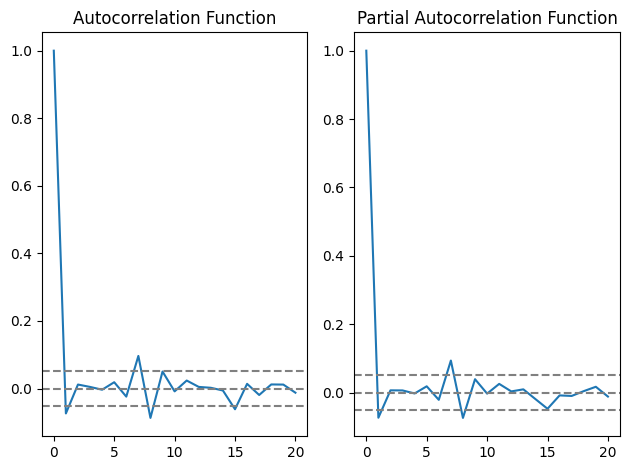

In [34]:
#ACF & PACF plots

lag_acf = acf(datasetLogDiffShifting, nlags=20)
lag_pacf = pacf(datasetLogDiffShifting, nlags=20, method='ols')

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')

plt.tight_layout()

A partir do gráfico ACF, vemos que a curva toca a linha y=0,0 em x=2 (Q = 2);

Do gráfico PACF, vemos que a curva toca a linha y=0,0 em x=2 (P = 2).

ARIMA é AR + I + MA. Antes, vemos um modelo ARIMA, vamos verificar os resultados do modelo AR & MA individual. Observe que esses modelos fornecerão um valor de RSS (Soma dos Quadrados dos Resíduos). Valores RSS mais baixos indicam um modelo melhor.

Com o RSS você está avaliando o quão longe seus pontos estão dos valores verdadeiros. Uma maneira de validar o seu modelo ARIMA é verificar se seu RSS diminui à medida que você faz alterações em seu modelo.

In [35]:
#! pip install --upgrade statsmodels

Plotting AR model


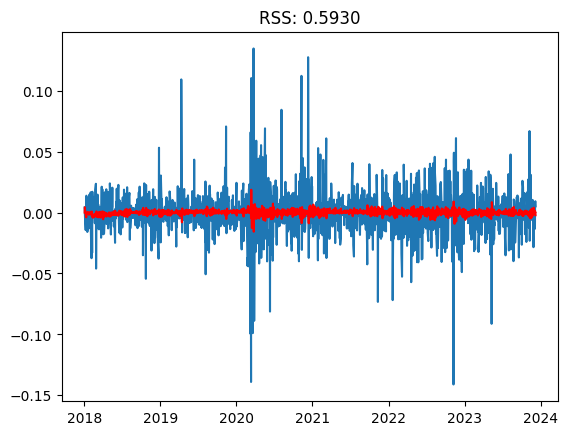

In [36]:
#AR Model
model = ARIMA(datasetLogDiffShifting, order=(2,1,2))#(p,d,q)
results_AR = model.fit()
plt.plot(datasetLogDiffShifting)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_AR.fittedvalues - datasetLogDiffShifting['Close'])**2))
print('Plotting AR model')

**Validando o modelo com MAPE  (Mean Absolute Percentage Error)**

 Métrica para valiar a precisão de previsões em séries temporais (perspectiva percentual dos erros). Quanto menor, melhor!
😊

In [37]:
from sklearn.metrics import mean_absolute_error

# Obtenha as previsões
predictions = results_AR.fittedvalues

# Ajuste os índices para garantir correspondência
predictions.index = datasetLogDiffShifting.index

# Inverta a diferenciação
# (indexedDataset_logScale['Close'].iloc[0]) para inverter a diferenciação.
# np.cumsum(predictions) é usado para calcular a soma cumulativa das previsões.
predicted_values = indexedDataset_logScale['Close'].iloc[0] + np.cumsum(predictions)

# Calcule o MAPE
mape = mean_absolute_error(datasetLogDiffShifting['Close'], predicted_values) * 100

print(f"MAPE: {mape:.2f}%")

MAPE: 470.61%


Um MAPE tão alto geralmente indica que as previsões do modelo estão muito distantes dos valores reais. 😞

# Testando o modelo com prophet 🔮

O prophet é uma ferramenta de previsão para séries temporais desenvolvida pelo Facebook. O Prophet é especialmente projetado para lidar com **séries temporais que possuem padrões sazonais fortes e vários pontos de mudança**.

O Prophet é um vidente, capaz de entender e prever tendências, sazonalidades e feriados.🔮 Mágico né?

O Prophet se destaca em sua capacidade de lidar com dados faltantes, tendências que mudam ao longo do tempo e até mesmo feriados! Ele foi projetado para ser flexível e intuitivo, tornando a previsão de séries temporais uma tarefa mais simples, mesmo para aqueles que não são especialistas em estatística.


In [38]:
# Especifique o símbolo da Disney (DIS) e o intervalo de datas desejado
symbol = 'DIS'
start_date = '2018-01-01'
end_date = '2023-12-11'

# Use a função download para obter os dados
df = yf.download(symbol, start=start_date, end=end_date)
df = df.reset_index('Date')
df['Date'] = pd.to_datetime(df['Date']) #realizando a conversão da data para formato datetime
df.drop(columns=['Open', 'High', 'Low', 'Volume', 'Adj Close'], inplace=True)
df[['ds','y']] = df[['Date','Close']]
df.head()



[*********************100%%**********************]  1 of 1 completed


,Date,Close,ds,y
0,2018-01-02,111.800003,2018-01-02,111.800003
1,2018-01-03,112.279999,2018-01-03,112.279999
2,2018-01-04,112.230003,2018-01-04,112.230003
3,2018-01-05,111.620003,2018-01-05,111.620003
4,2018-01-08,110.019997,2018-01-08,110.019997


## Seprando os dados em treino e teste

In [39]:
train_data = df.sample(frac=0.8, random_state=0)
test_data = df.drop(train_data.index)
print(f'training data size : {train_data.shape}')
print(f'testing data size : {test_data.shape}')

training data size : (1196, 4)
testing data size : (299, 4)


In [40]:
modelo = Prophet(daily_seasonality=True)
modelo.fit(train_data)
dataFramefuture = modelo.make_future_dataframe(periods=30, freq='D')
previsao = modelo.predict(dataFramefuture)
previsao.head()

DEBUG:cmdstanpy:input tempfile: /tmp/tmpbr0v691p/enzc54y2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbr0v691p/m7xsl8zh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2233', 'data', 'file=/tmp/tmpbr0v691p/enzc54y2.json', 'init=/tmp/tmpbr0v691p/m7xsl8zh.json', 'output', 'file=/tmp/tmpbr0v691p/prophet_modelngkeeo91/prophet_model-20240104011315.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:13:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:13:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-01-02,108.799811,98.769534,117.433183,108.799811,108.799811,-0.497071,-0.497071,-0.497071,-5.739615,...,0.080268,0.080268,0.080268,5.162276,5.162276,5.162276,0.0,0.0,0.0,108.302740
1,2018-01-03,108.826460,99.100866,117.225734,108.826460,108.826460,-0.730227,-0.730227,-0.730227,-5.739615,...,-0.325780,-0.325780,-0.325780,5.335168,5.335168,5.335168,0.0,0.0,0.0,108.096233
2,2018-01-04,108.853108,98.484097,117.694397,108.853108,108.853108,-0.799401,-0.799401,-0.799401,-5.739615,...,-0.540403,-0.540403,-0.540403,5.480617,5.480617,5.480617,0.0,0.0,0.0,108.053707
3,2018-01-05,108.879756,100.319707,117.405649,108.879756,108.879756,-0.693985,-0.693985,-0.693985,-5.739615,...,-0.550844,-0.550844,-0.550844,5.596474,5.596474,5.596474,0.0,0.0,0.0,108.185771
4,2018-01-08,108.959701,99.822492,118.093535,108.959701,108.959701,-0.082507,-0.082507,-0.082507,-5.739615,...,-0.098144,-0.098144,-0.098144,5.755252,5.755252,5.755252,0.0,0.0,0.0,108.877194


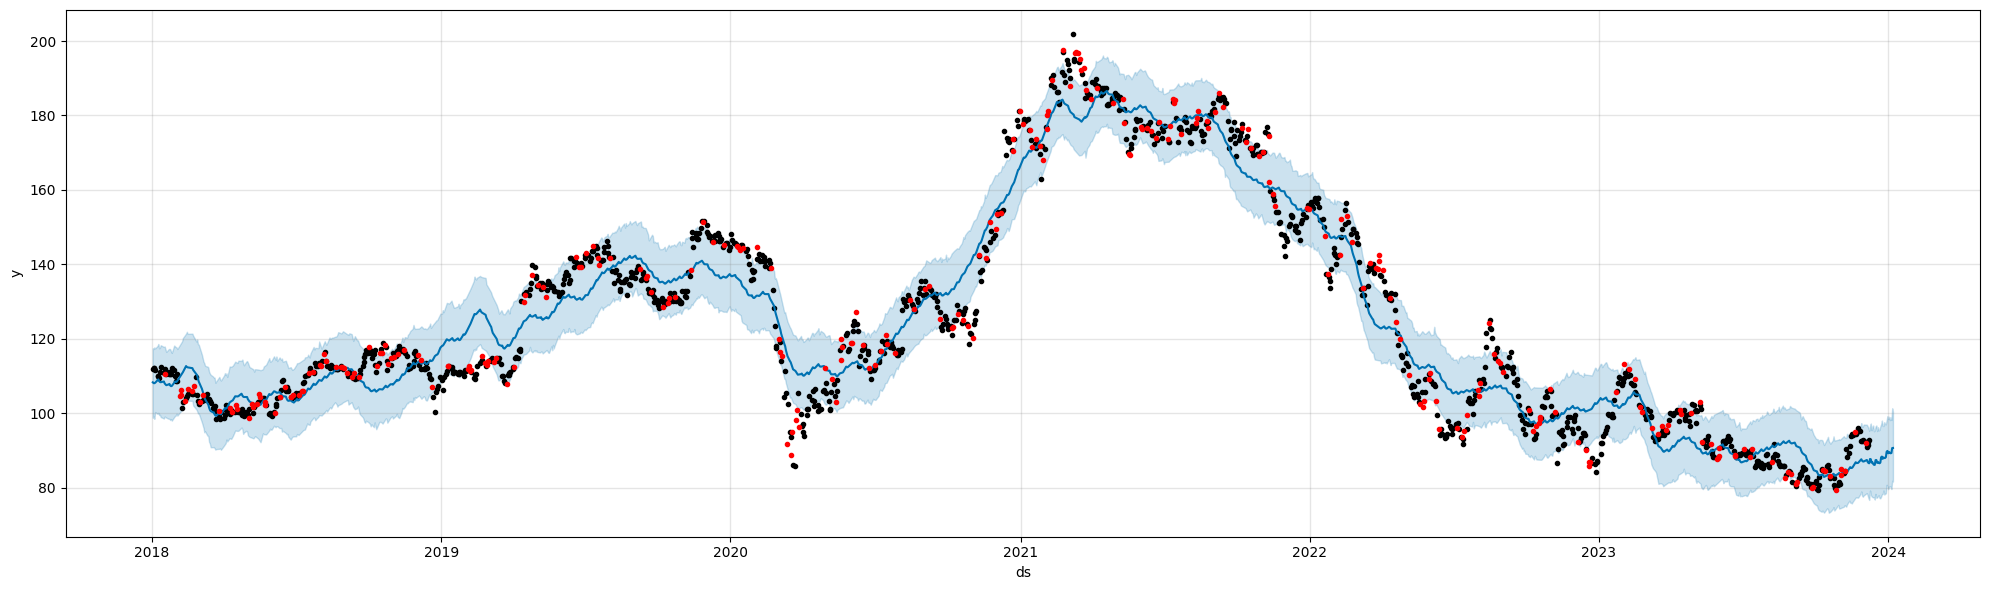

In [41]:
modelo.plot(previsao, figsize=(20,6));
plt.plot(test_data['ds'], test_data['y'], '.r')

Uma das características mais úteis do Prophet é sua capacidade de decompor automaticamente uma série temporal em seus componentes. Isso inclui a tendência geral, sazonalidade anual e efeitos de feriados (se fornecidos)

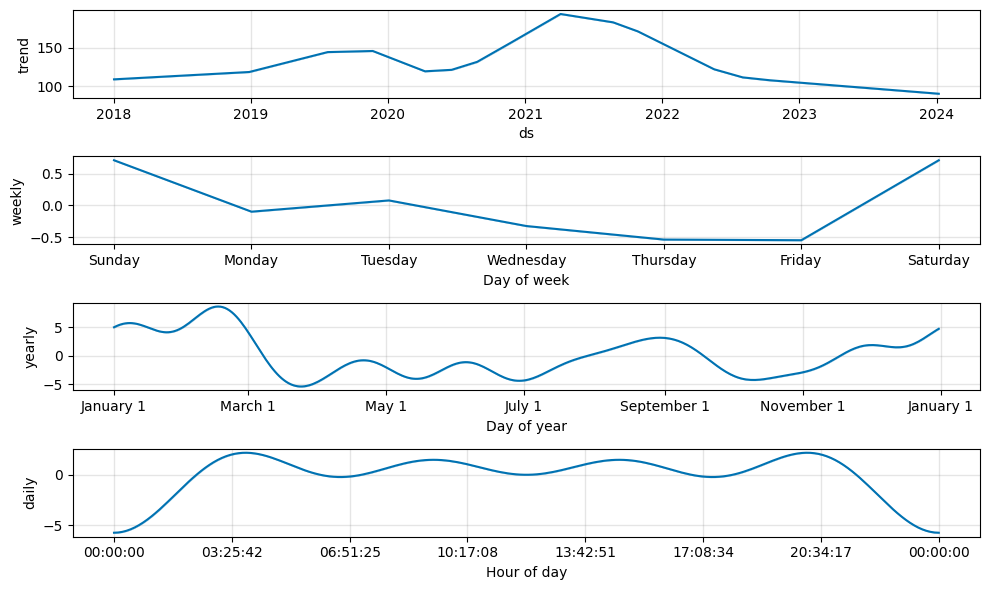

In [42]:
modelo.plot_components(previsao, figsize=(10,6));

**Adicionando Changepoints no modelo**

O prophet permite adicionar pontos de mudanças na série temporal, o que nos permite identificar em quais datas ocorrem possíveis mudanças.

In [43]:
from prophet.plot import add_changepoints_to_plot

modelo_changepoints = Prophet(n_changepoints=5)
modelo_changepoints.fit(train_data)
dataFramefuture = modelo_changepoints.make_future_dataframe(periods=30, freq='D')
previsao_changepoints = modelo_changepoints.predict(dataFramefuture)
previsao_changepoints.head()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbr0v691p/j7md_5ko.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbr0v691p/c8t3ll_q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65567', 'data', 'file=/tmp/tmpbr0v691p/j7md_5ko.json', 'init=/tmp/tmpbr0v691p/c8t3ll_q.json', 'output', 'file=/tmp/tmpbr0v691p/prophet_modelhr64yclh/prophet_model-20240104011318.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:13:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:13:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-01-02,103.068596,90.649350,125.084261,103.068596,103.068596,4.462904,4.462904,4.462904,-0.827499,-0.827499,-0.827499,5.290403,5.290403,5.290403,0.0,0.0,0.0,107.531499
1,2018-01-03,103.111061,90.047675,126.242170,103.111061,103.111061,3.613815,3.613815,3.613815,-1.879974,-1.879974,-1.879974,5.493789,5.493789,5.493789,0.0,0.0,0.0,106.724876
2,2018-01-04,103.153525,88.810072,123.757795,103.153525,103.153525,3.375955,3.375955,3.375955,-2.291565,-2.291565,-2.291565,5.667520,5.667520,5.667520,0.0,0.0,0.0,106.529480
3,2018-01-05,103.195990,89.056380,124.136410,103.195990,103.195990,4.109867,4.109867,4.109867,-1.698720,-1.698720,-1.698720,5.808587,5.808587,5.808587,0.0,0.0,0.0,107.305857
4,2018-01-08,103.323385,91.013576,124.740594,103.323385,103.323385,4.350869,4.350869,4.350869,-1.665512,-1.665512,-1.665512,6.016381,6.016381,6.016381,0.0,0.0,0.0,107.674254


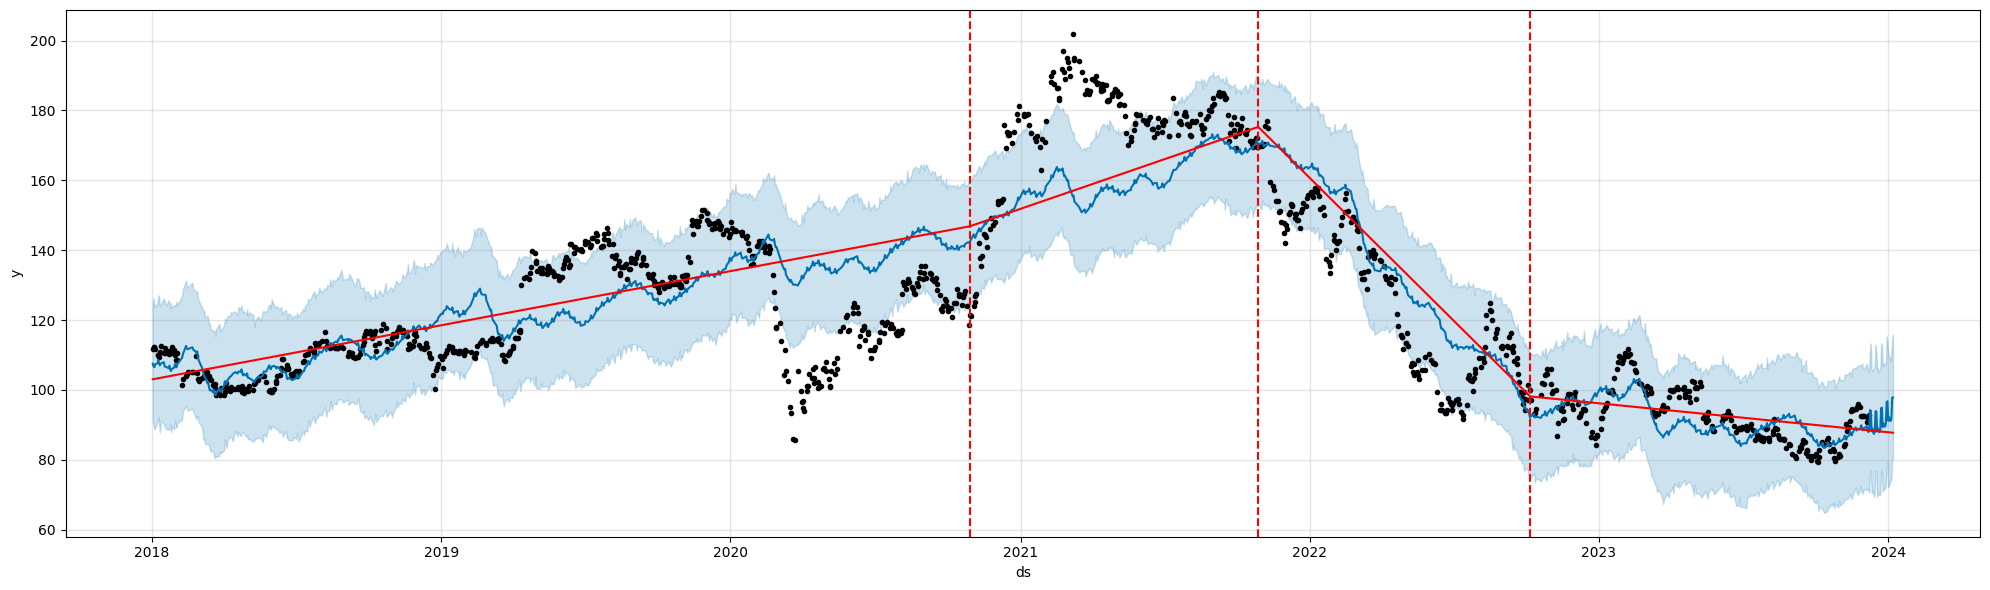

In [44]:
fig = modelo_changepoints.plot(previsao_changepoints, figsize=(20,6));
a = add_changepoints_to_plot(fig.gca(), modelo_changepoints, previsao_changepoints)

In [45]:

# Extrair as colunas relevantes dos DataFrames
previsao_cols = ['ds', 'yhat']
valores_reais_cols = ['ds', 'y']

previsao = previsao[previsao_cols]
valores_reais = train_data[valores_reais_cols]

# Mesclar os DataFrames nas colunas 'ds' para comparar previsões e valores reais
resultados = pd.merge(previsao, valores_reais, on='ds', how='inner')

# Calcular o erro percentual absoluto para cada ponto de dados
resultados['erro_percentual_absoluto'] = np.abs((resultados['y'] - resultados['yhat']) / resultados['y']) * 100

# Calcular o MAPE
mape = np.mean(resultados['erro_percentual_absoluto'])

print(f"MAPE: {mape:.2f}%")

MAPE: 4.98%


## Cross validation

Para concluir o modelo do Prophet, tentei fazer a validação cruzada para testar dados que nunca foram vistos pelo modelo antes.

Observe que no resultado da validação cruzada temos os valores de yhat, yhat_lower, yhat_upper e o ponto de corte. O objetivo da validação cruzada é medir o erro de predição, selecionando assim pontos de corte e para cada um desses pontos o modelo é ajustado utilizando dados apenas até aquele ponto de corte.


In [46]:
from prophet.diagnostics import cross_validation

df_cv = cross_validation(modelo, initial='730 days', period='180 days', horizon = '365 days')


INFO:prophet:Making 6 forecasts with cutoffs between 2020-06-21 00:00:00 and 2022-12-08 00:00:00


  0%|          | 0/6 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpbr0v691p/t81n9wk3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbr0v691p/9m8ez4xf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3075', 'data', 'file=/tmp/tmpbr0v691p/t81n9wk3.json', 'init=/tmp/tmpbr0v691p/9m8ez4xf.json', 'output', 'file=/tmp/tmpbr0v691p/prophet_model2d8mazxu/prophet_model-20240104011319.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:13:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:13:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbr0v691p/3623lf9w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbr0v691p/b8877ypp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

In [47]:
df_cv.head()


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-06-22,110.417340,103.072468,117.659187,115.919998,2020-06-21
1,2020-06-23,110.271440,102.820220,117.601279,116.589996,2020-06-21
2,2020-06-25,109.989221,102.781622,117.579474,111.360001,2020-06-21
3,2020-06-26,109.436337,102.486217,116.675934,109.099998,2020-06-21
4,2020-06-29,108.835404,101.509150,116.165381,111.519997,2020-06-21


In [81]:
df_cv['cutoff'].unique()

array(['2020-06-21T00:00:00.000000000', '2020-12-18T00:00:00.000000000',
       '2021-06-16T00:00:00.000000000', '2021-12-13T00:00:00.000000000',
       '2022-06-11T00:00:00.000000000', '2022-12-08T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [48]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,39 days,227.356982,15.078361,13.182917,0.098552,0.096021,0.096327,0.287500
1,40 days,229.351728,15.144363,13.246969,0.099509,0.093862,0.097469,0.277778
2,41 days,230.192763,15.172105,13.251699,0.099365,0.093628,0.097617,0.283333
3,42 days,235.559366,15.347943,13.444974,0.100591,0.093628,0.099017,0.275000
4,43 days,246.161987,15.689550,13.828933,0.102913,0.096115,0.101608,0.255556
...,...,...,...,...,...,...,...,...
322,361 days,7934.112202,89.073634,76.556119,0.660277,0.545065,0.694525,0.372222
323,362 days,8010.507536,89.501439,77.335047,0.665880,0.545065,0.702961,0.365000
324,363 days,8108.114890,90.045071,77.790185,0.674195,0.545065,0.704452,0.362500
325,364 days,8088.148747,89.934136,77.517836,0.673052,0.541107,0.698175,0.366667


https://facebook.github.io/prophet/docs/diagnostics.html

### Aplicando o algoritmo LSTM para prever 🤖

Vamos agora utilizar uma Rede LSTM (Long Short-Term Memory) para prever o comportamento da empresa.

LSTM é um tipo especial de **rede neural recorrente**, pois são capazes de aprender conexões de longo prazo. Dessa maneira, elas têm um incrível poder de predição e funcionam muito bem em uma variada gama de problemas que envolvem capturas de padrões de longo prazo em séries temporais, textos longos, gravações de áudios e muito mais. O principal trabalho dessa rede neural se torna entender como uma memória deve influenciar a outra, ou seja, como a rede decide quais partes da memória de curto prazo devem ser lembradas e como a memória de longo prazo deve afetar o entendimento atual do texto.



In [49]:
df = df_disney
df['Date'] = pd.to_datetime(df['Date']) #realizando a conversão da data para formato datetime
df.drop(columns=['Open', 'High', 'Low', 'Volume', 'Adj Close'], inplace=True)

df.head()

,Date,Close
0,2018-01-02,111.800003
1,2018-01-03,112.279999
2,2018-01-04,112.230003
3,2018-01-05,111.620003
4,2018-01-08,110.019997


In [50]:
close_data = df['Close'].values
close_data = close_data.reshape(-1,1) #transformar em array

### Normalizando os dados

In [51]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(close_data)
close_data = scaler.transform(close_data)

### Separação da base de treino e teste:

In [52]:
split_percent = 0.80
split = int(split_percent*len(close_data))

close_train = close_data[:split]
close_test = close_data[split:]

date_train = df['Date'][:split]
date_test = df['Date'][split:]

print(len(close_train))
print(len(close_test))

1196
299


In [53]:
# Gerar sequências temporais para treinamento e teste em um modelo de aprendizado de máquina

look_back = 10

train_generator = TimeseriesGenerator(close_train, close_train, length=look_back, batch_size=20)
test_generator = TimeseriesGenerator(close_test, close_test, length=look_back, batch_size=1)

In [54]:
from tensorflow.keras.metrics import MeanSquaredError

np.random.seed(7)

model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(look_back,1)))
model.add(Dense(1)),

model.compile(optimizer='adam', loss='mse', metrics=[MeanSquaredError()])

num_epochs = 20
model.fit(train_generator, epochs=num_epochs, verbose=1)

Epoch 1/20
60/60 [==============================] - 2s 10ms/step - loss: 0.0897 - mean_squared_error: 0.0897
Epoch 2/20
60/60 [==============================] - 0s 7ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 3/20
60/60 [==============================] - 0s 7ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 4/20
60/60 [==============================] - 0s 7ms/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 5/20
60/60 [==============================] - 0s 7ms/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 6/20
60/60 [==============================] - 0s 6ms/step - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 7/20
60/60 [==============================] - 0s 6ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 8/20
60/60 [==============================] - 0s 6ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 9/20
60/60 [==============================] - 0s 6ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 10/20
60/60 [========

In [55]:
# Avaliando o modelo nos dados de teste
mse = model.evaluate(test_generator, verbose=1)
print("Erro Quadrático Médio", mse[0])

289/289 [==============================] - 2s 5ms/step - loss: 6.7526e-04 - mean_squared_error: 6.7526e-04
Erro Quadrático Médio 0.0006752634653821588


In [56]:
# 1. Fazer previsões usando o conjunto de teste
test_predictions = model.predict(test_generator)

# 2. Inverter qualquer transformação aplicada aos dados
test_predictions_inv = scaler.inverse_transform(test_predictions.reshape(-1, 1))
test_actuals_inv = scaler.inverse_transform(np.array(close_test).reshape(-1, 1))

# Ajuste as dimensões
test_actuals_inv = test_actuals_inv[:len(test_predictions_inv)]

# Calcular o MAPE
mape = np.mean(np.abs((test_actuals_inv - test_predictions_inv) / test_actuals_inv)) * 100

# Imprimir o MAPE
print(f'MAPE: {mape:.4f}')


289/289 [==============================] - 1s 3ms/step
MAPE: 3.2914


In [57]:
#O RMSE é a raiz quadrada do MSE (Mean Squared Error), que é a média dos quadrados das diferenças entre as previsões do modelo e os valores reais.
rmse_value = np.sqrt(mse[0])

print("RMSE:", rmse_value)

RMSE: 0.02598583201250556


O RMSE fornece uma métrica de erro na mesma unidade que a variável alvo (nesse caso, o preço de fechamento). Portanto significa que, em média, as previsões do modelo estão desviando em torno de 0.024 unidades da variável de destino. Quanto menor o RMSE, melhor é o desempenho do modelo em termos de previsões de regressão. Esse modelo ficou top né?

In [58]:
prediction = model.predict(test_generator)

close_train = close_train.reshape((-1))
close_test = close_test.reshape((-1))
prediction = prediction.reshape((-1))

trace1 = go.Scatter(
    x = date_train,
    y = close_train,
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = date_test,
    y = prediction,
    mode = 'lines',
    name = 'Prediction'
)
trace3 = go.Scatter(
    x = date_test,
    y = close_test,
    mode='lines',
    name = 'Ground Truth'
)
layout = go.Layout(
    title = "Predições da Disney",
    xaxis = {'title' : "Data"},
    yaxis = {'title' : "Fechamento"}
)
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.show()

289/289 [==============================] - 1s 3ms/step


Será que podemos melhorar esses resultados?

# Validando com suavização da série temporal

In [59]:
df = df_disney
df['Date'] = pd.to_datetime(df['Date']) #realizando a conversão da data para formato datetime
df.head()

,Date,Close
0,2018-01-02,111.800003
1,2018-01-03,112.279999
2,2018-01-04,112.230003
3,2018-01-05,111.620003
4,2018-01-08,110.019997


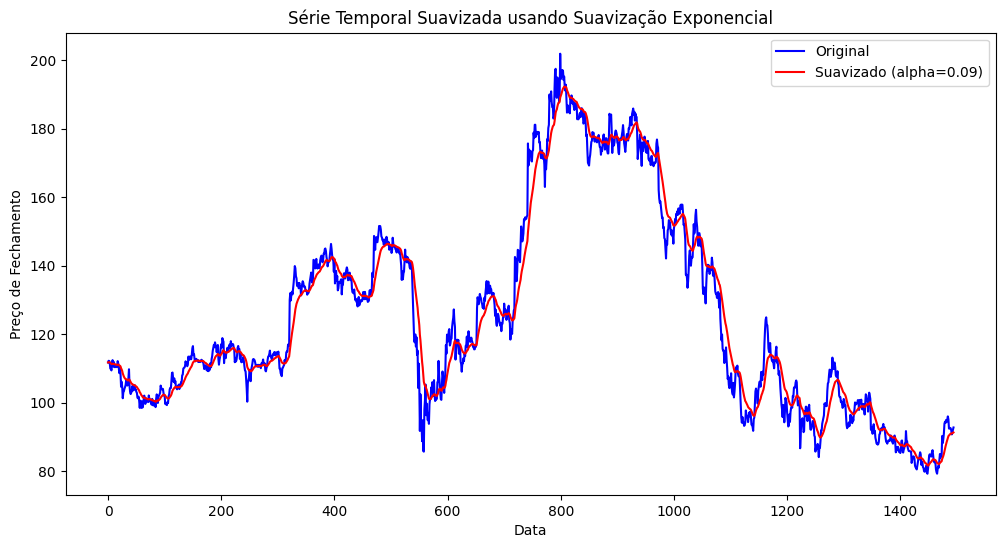

In [60]:
# Suazivando a série temporal
# Aplicando suavização exponencial
alpha = 0.09   # Fator de suavização
# O parâmetro alpha na suavização exponencial controla a taxa de decaimento dos pesos atribuídos às observações passadas.
# Determina o quão rapidamente o impacto das observações antigas diminui à medida que você avança no tempo.

df['Smoothed_Close'] = df['Close'].ewm(alpha=alpha, adjust=False).mean()

# Visualizando os resultados
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='Original', color='blue')
plt.plot(df.index, df['Smoothed_Close'], label=f'Suavizado (alpha={alpha})', color='red')
plt.title('Série Temporal Suavizada usando Suavização Exponencial')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.legend()
plt.show()

In [61]:
# Teste de estacionariedade (ADF Test)
adf_result = adfuller(df['Smoothed_Close'] )
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
print('Resultados do Teste de Estacionariedade:')
print('--------------------------------------')
print('Teste Estatístico:', adf_result[0])
print('Valor-p:', adf_result[1])
print('Valores Críticos:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -1.5904644881440193
p-value: 0.48838174254532385
Resultados do Teste de Estacionariedade:
--------------------------------------
Teste Estatístico: -1.5904644881440193
Valor-p: 0.48838174254532385
Valores Críticos:
   1%: -3.43476120520139
   5%: -2.863488262178673
   10%: -2.567807233388883


In [62]:
df.drop(columns=['Close'], inplace=True)
df.head()

,Date,Smoothed_Close
0,2018-01-02,111.800003
1,2018-01-03,111.843203
2,2018-01-04,111.878015
3,2018-01-05,111.854794
4,2018-01-08,111.689662


In [63]:
close_data = df['Smoothed_Close'].values
close_data = close_data.reshape(-1,1) #transformar em array

scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(close_data)
close_data = scaler.transform(close_data)

In [64]:
close_data

array([[0.27223544],
       [0.27262606],
       [0.27294083],
       ...,
       [0.08519177],
       [0.08619743],
       [0.08749506]])

In [65]:
split_percent = 0.80
split = int(split_percent*len(close_data))

close_train = close_data[:split]
close_test = close_data[split:]

date_train = df['Date'][:split]
date_test = df['Date'][split:]

print(len(close_train))
print(len(close_test))

1196
299


In [66]:
# Gerar sequências temporais para treinamento e teste em um modelo de aprendizado de máquina

look_back = 5

train_generator = TimeseriesGenerator(close_train, close_train, length=look_back, batch_size=20)
test_generator = TimeseriesGenerator(close_test, close_test, length=look_back, batch_size=1)

In [67]:
np.random.seed(7)

model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(look_back,1)))
model.add(Dense(1)),

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=[MeanSquaredError()])

num_epochs = 100
model.fit(train_generator, epochs=num_epochs, verbose=1)

Epoch 1/100
60/60 [==============================] - 2s 4ms/step - loss: 0.1141 - mean_squared_error: 0.1141
Epoch 2/100
60/60 [==============================] - 0s 4ms/step - loss: 0.0086 - mean_squared_error: 0.0086
Epoch 3/100
60/60 [==============================] - 0s 5ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 4/100
60/60 [==============================] - 0s 5ms/step - loss: 4.3039e-04 - mean_squared_error: 4.3039e-04
Epoch 5/100
60/60 [==============================] - 0s 4ms/step - loss: 3.7904e-04 - mean_squared_error: 3.7904e-04
Epoch 6/100
60/60 [==============================] - 0s 4ms/step - loss: 3.4859e-04 - mean_squared_error: 3.4859e-04
Epoch 7/100
60/60 [==============================] - 0s 4ms/step - loss: 3.2702e-04 - mean_squared_error: 3.2702e-04
Epoch 8/100
60/60 [==============================] - 0s 4ms/step - loss: 3.0965e-04 - mean_squared_error: 3.0965e-04
Epoch 9/100
60/60 [==============================] - 0s 4ms/step - loss: 2.7460e-04 - me

In [68]:
# 1. Fazer previsões usando o conjunto de teste
test_predictions = model.predict(test_generator)

# 2. Inverter qualquer transformação aplicada aos dados
test_predictions_inv = scaler.inverse_transform(test_predictions.reshape(-1, 1))
test_actuals_inv = scaler.inverse_transform(np.array(close_test).reshape(-1, 1))

# Ajuste as dimensões
test_actuals_inv = test_actuals_inv[:len(test_predictions_inv)]

# Calcular o MAPE
mape = np.mean(np.abs((test_actuals_inv - test_predictions_inv) / test_actuals_inv)) * 100

# Imprimir o MAPE
print(f"MAPE: {mape:.2f}%")


294/294 [==============================] - 1s 2ms/step
MAPE: 1.06%


In [69]:
# Avaliando o modelo nos dados de teste
mse = model.evaluate(test_generator, verbose=1)
print("Erro Quadrático Médio:", mse[0])

294/294 [==============================] - 1s 2ms/step - loss: 1.3411e-04 - mean_squared_error: 1.3411e-04
Erro Quadrático Médio: 0.00013411015970632434


In [70]:
# O RMSE é a raiz quadrada do MSE (Mean Squared Error), que é a média dos quadrados das diferenças entre as previsões do modelo e os valores reais.
rmse_value = np.sqrt(mse[0])

print("RMSE:", rmse_value)

RMSE: 0.011580594099886427


Plotando os resultados! 📈

In [71]:
prediction = model.predict(test_generator)

close_train = close_train.reshape((-1))
close_test = close_test.reshape((-1))
prediction = prediction.reshape((-1))

trace1 = go.Scatter(
    x = date_train,
    y = close_train,
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = date_test,
    y = prediction,
    mode = 'lines',
    name = 'Prediction'
)
trace3 = go.Scatter(
    x = date_test,
    y = close_test,
    mode='lines',
    name = 'Ground Truth'
)
layout = go.Layout(
    title = "Predições da Disney",
    xaxis = {'title' : "Data"},
    yaxis = {'title' : "Fechamento"}
)
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.show()

294/294 [==============================] - 1s 2ms/step


# Realizando o Forecasting  🔮

Agora chegou o momento de prever o futuro!

Vamos criar uma função para prever o futuro, vamos passar como parametro um  número X de dias e a ideia dessa função é excutar o predict do modelo para nos retornar os dias futuros.

In [72]:
close_data = close_data.reshape((-1))


# Função para prever os próximos 'num_prediction' pontos da série temporal
# Utiliza o modelo treinado para prever cada ponto sequencialmente
# A cada iteração, adiciona a previsão à lista 'prediction_list'

def predict(num_prediction, model):
    prediction_list = close_data[-look_back:]

    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]

    return prediction_list

# Função para gerar as datas dos próximos 'num_prediction' dias
# Assume que o DataFrame 'df' possui uma coluna 'Date' contendo as datas

def predict_dates(num_prediction):
    last_date = df['Date'].values[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
    return prediction_dates

num_prediction = 15 #definição dos próximos dias
forecast = predict(num_prediction, model) #resultado de novos dias
forecast_dates = predict_dates(num_prediction)

1/1 [==============================] - 0s 18ms/step


In [73]:
trace1 = go.Scatter(
    x = date_test,
    y = close_test,
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = forecast_dates,
    y = forecast,
    mode = 'lines',
    name = 'Prediction'
)
layout = go.Layout(
    title = "Forecast Disney",
    xaxis = {'title' : "Data"},
    yaxis = {'title' : "Fechamento"}
)
fig = go.Figure(data=[trace1, trace2], layout=layout)
fig.show()

# Organizando os dados em um dataframe

In [74]:
df = pd.DataFrame(df)
df_past = df[['Date','Smoothed_Close']]
df_past.rename(columns={'Smoothed_Close': 'Actual'}, inplace=True)         #criando nome das colunas
df_past['Date'] = pd.to_datetime(df_past['Date'])                          #configurando para datatime
df_past['Forecast'] = np.nan                                               #Preenchendo com NAs
df_past['Forecast'].iloc[-1] = df_past['Actual'].iloc[-1]
df_past.head(3)

,Date,Actual,Forecast
0,2018-01-02,111.800003,NaN
1,2018-01-03,111.843203,NaN
2,2018-01-04,111.878015,NaN


In [75]:
# Faz a transformação inversa das predições
forecast = forecast.reshape(-1, 1) #reshape para array
forecast = scaler.inverse_transform(forecast)

In [76]:
df_future = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_future['Date'] = forecast_dates
df_future['Forecast'] = forecast.flatten()
df_future['Actual'] = np.nan
df_future.head()

,Date,Actual,Forecast
0,2023-12-08,NaN,91.368958
1,2023-12-09,NaN,91.873816
2,2023-12-10,NaN,92.050426
3,2023-12-11,NaN,92.253967
4,2023-12-12,NaN,92.474208


In [77]:
# Concatenando os DataFrames usando concat
frames = [df_past, df_future]
results = pd.concat(frames, ignore_index=True).set_index('Date')
results.head()

,Actual,Forecast
Date,,
2018-01-02,111.800003,NaN
2018-01-03,111.843203,NaN
2018-01-04,111.878015,NaN
2018-01-05,111.854794,NaN
2018-01-08,111.689662,NaN


In [78]:
results.tail()

,Actual,Forecast
Date,,
2023-12-19,NaN,93.925409
2023-12-20,NaN,94.111958
2023-12-21,NaN,94.295204
2023-12-22,NaN,94.474559
2023-12-23,NaN,94.649853


In [79]:
results2023 =  results.loc['2023-01-01':]

In [82]:
plot_data = [
    go.Scatter(
        x=results2023.index,
        y=results2023['Actual'],
        name='actual'
    ),
    go.Scatter(
        x=results2023.index,
        y=results2023['Forecast'],
        name='prediction'
    )
]

plot_layout = go.Layout(
        title='Forecast Disney'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)

fig.show()

import plotly as ply
ply.offline.plot(fig)

'temp-plot.html'